In [261]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import autoreload
import os, os.path
from collections import namedtuple

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output

from tia.bbg import LocalTerminal

import pyfolio as pf
from statsmodels.graphics.gofplots import qqplot

fldr = r"C:\Users\troy\Documents\Excel Sheets\Blotter Dump"
filename = "RP_NAV.csv"
filepath = os.path.join(fldr, filename)

df = pd.read_csv(filepath, header=0)
# df = df.set_index("Date")
dates = [pd.datetime.strptime(dt, "%d/%m/%Y").date() for dt in df['Date']]
date_index = pd.DatetimeIndex(dates)
NAV = df['NAV']
NAV = pd.Series(NAV.values, date_index)
NAV_ret_perf = NAV.pct_change()

eff_start_date = date(2005, 11, 8)
NAV_ret_perf = NAV_ret_perf[eff_start_date:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32


C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


## Sharpe ratio Scaler Positioning

In [95]:
SharpeScaler = namedtuple('SharpeScaler', ['ts', 'window', 'ref_sharpe', 'sharpe_scale', 'pos', 'scaled_ret', 'scaled_nav'])

def create_rollingsharpe_scaling(ts_returns, window, ref_sharpe, sharpe_scale):
    ts_roll_mean = ts_returns.rolling(window, min_periods=2).mean()
    ts_roll_vol = ts_returns.rolling(window, min_periods=2).std()
    ts_sharpe = ts_roll_mean / ts_roll_vol * np.sqrt(252)
    ts_sharpe_scale = 1 - np.arctan((ts_sharpe - ref_sharpe) / sharpe_scale)
    pos_adjust = ts_sharpe_scale.ewm(span=window/2).mean()
    pos = pos_adjust.fillna(1)
    scaled_ret = (ts_returns * pos.shift(1)).fillna(0)
    scaled_nav = (1 + scaled_ret).cumprod() * 100
    result = SharpeScaler(ts_returns, window, ref_sharpe, sharpe_scale, pos, scaled_ret, scaled_nav)
    return result

def print_stats(ts_returns):
    mean = ts_returns.mean() * 252
    vol = ts_returns.std() * np.sqrt(252)
    upside_vol = (ts_returns[ts_returns > 0]).std() * np.sqrt(252)
    dnside_vol = (ts_returns[ts_returns <= 0]).std() * np.sqrt(252)
    nav = (1 + ts_returns).cumprod() * 100
    
    sharpe = mean / vol
    sortino = mean / dnside_vol
    
    print("*****************************")
    print("Mean (Ann.): %s" % mean)
    print("Vol (Ann.): %s" % vol)
    print("Vol Upside (Ann.): %s" % upside_vol)
    print("Vol Downside (Ann.): %s" % dnside_vol)

    print("*****************************")
    print("Sharpe (Ann.): %s" % sharpe)
    print("Sortino (Ann.): %s" % sortino)

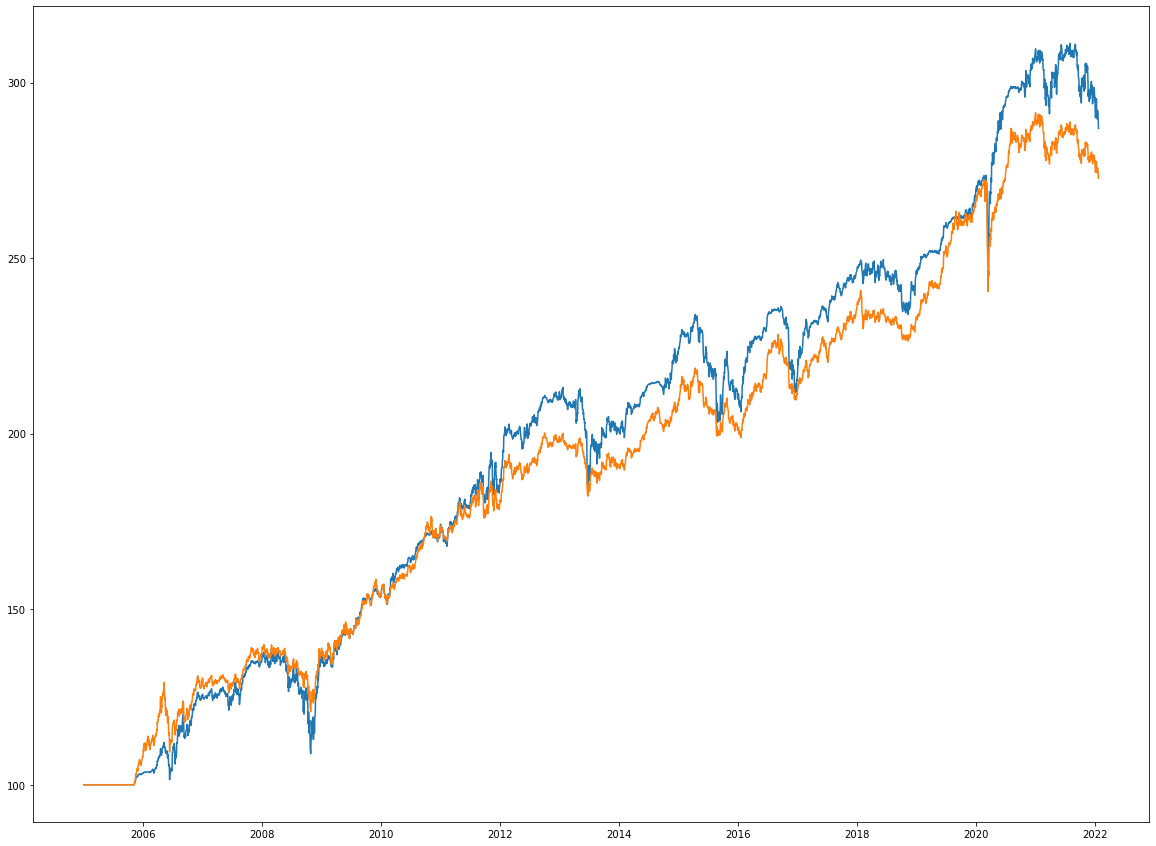

In [235]:
NAV_ret = NAV_ret_perf
window = 60
ref_sharpe = 1.5
sharpe_scale = 3

results = create_rollingsharpe_scaling(NAV_ret, window, ref_sharpe, sharpe_scale)
plt.plot(results.scaled_nav)
plt.plot(NAV)

## Analysis of Returns

### Summary of returns for NAV

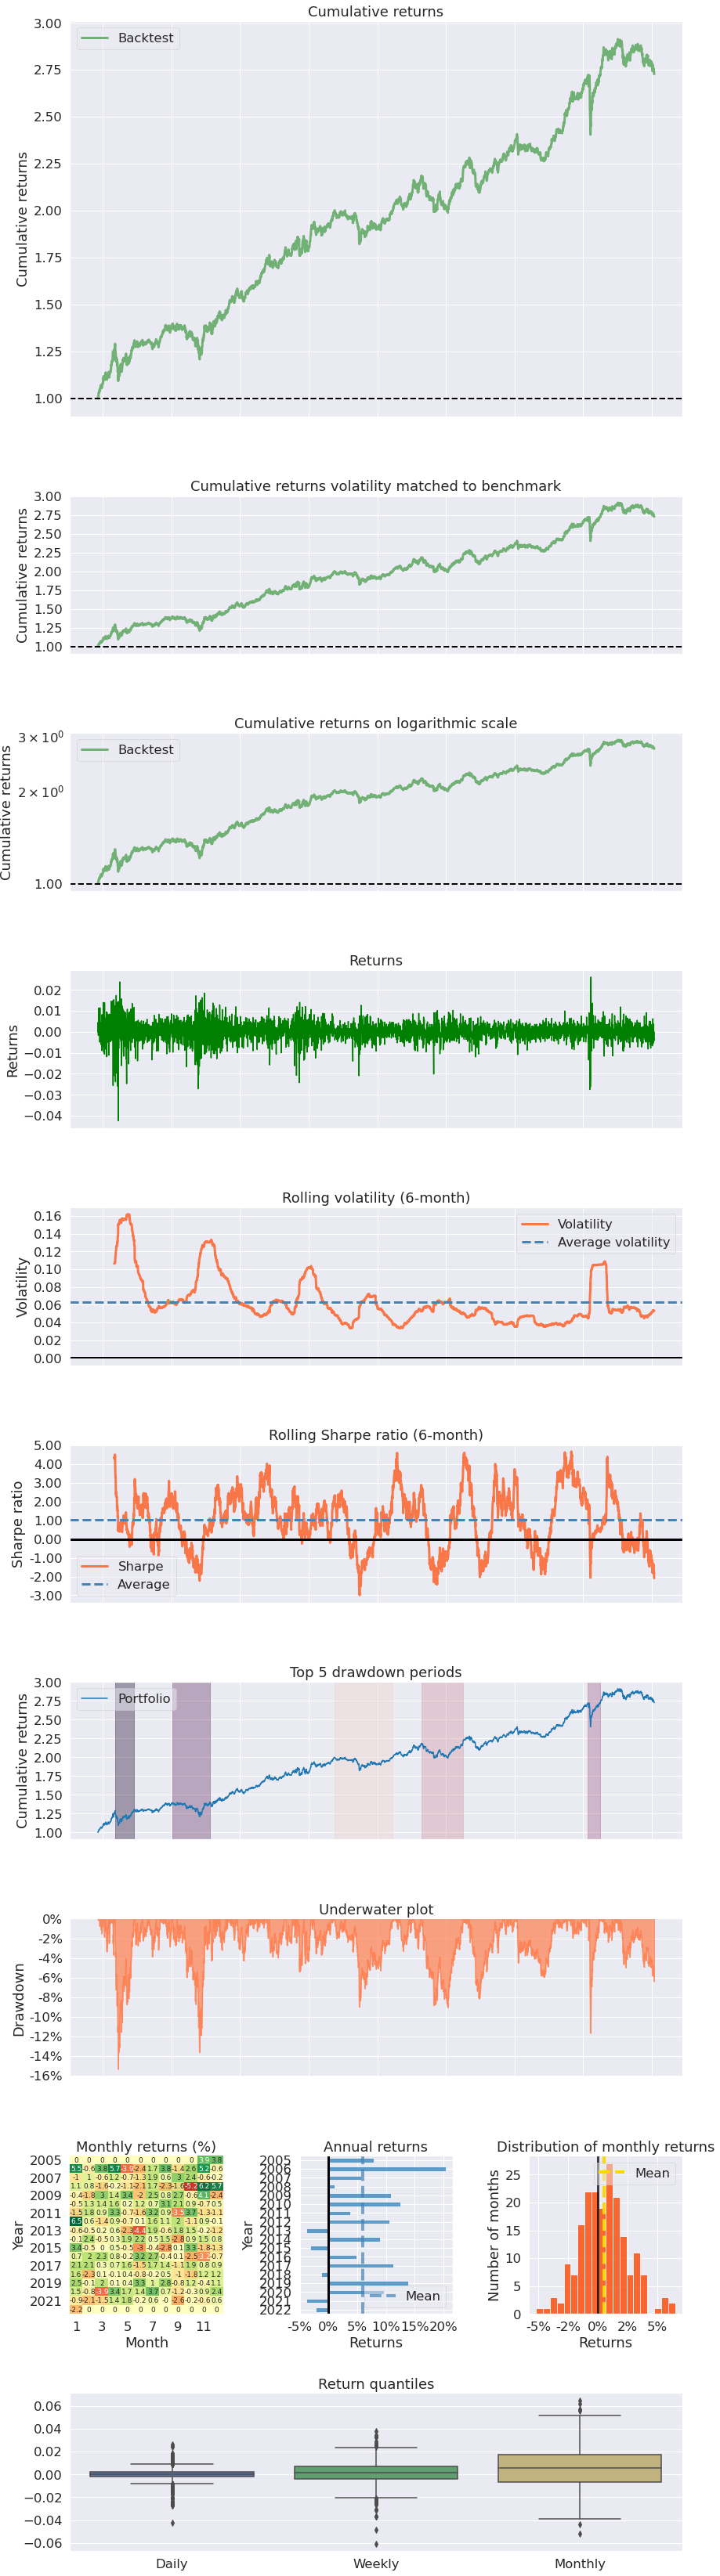

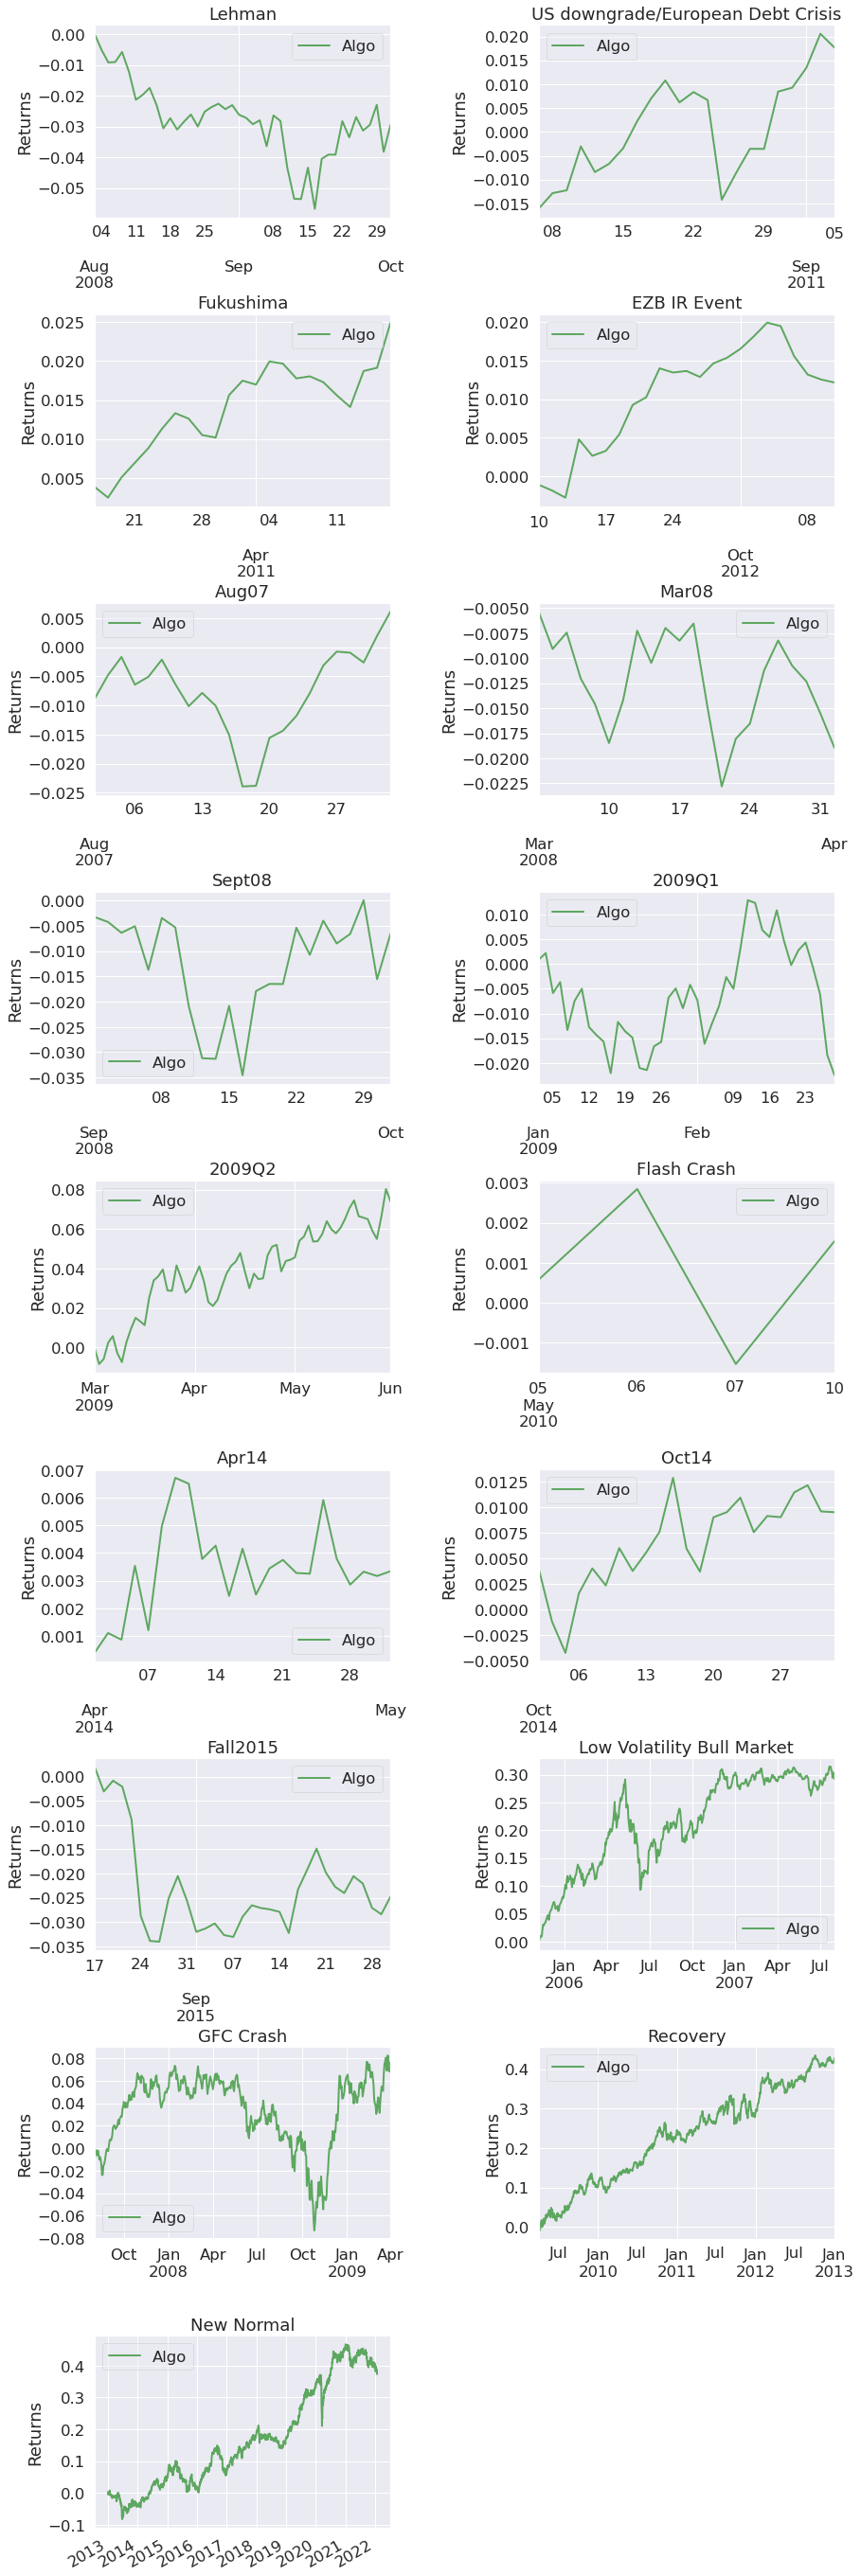

In [548]:
pf.create_full_tear_sheet(NAV_ret_perf)

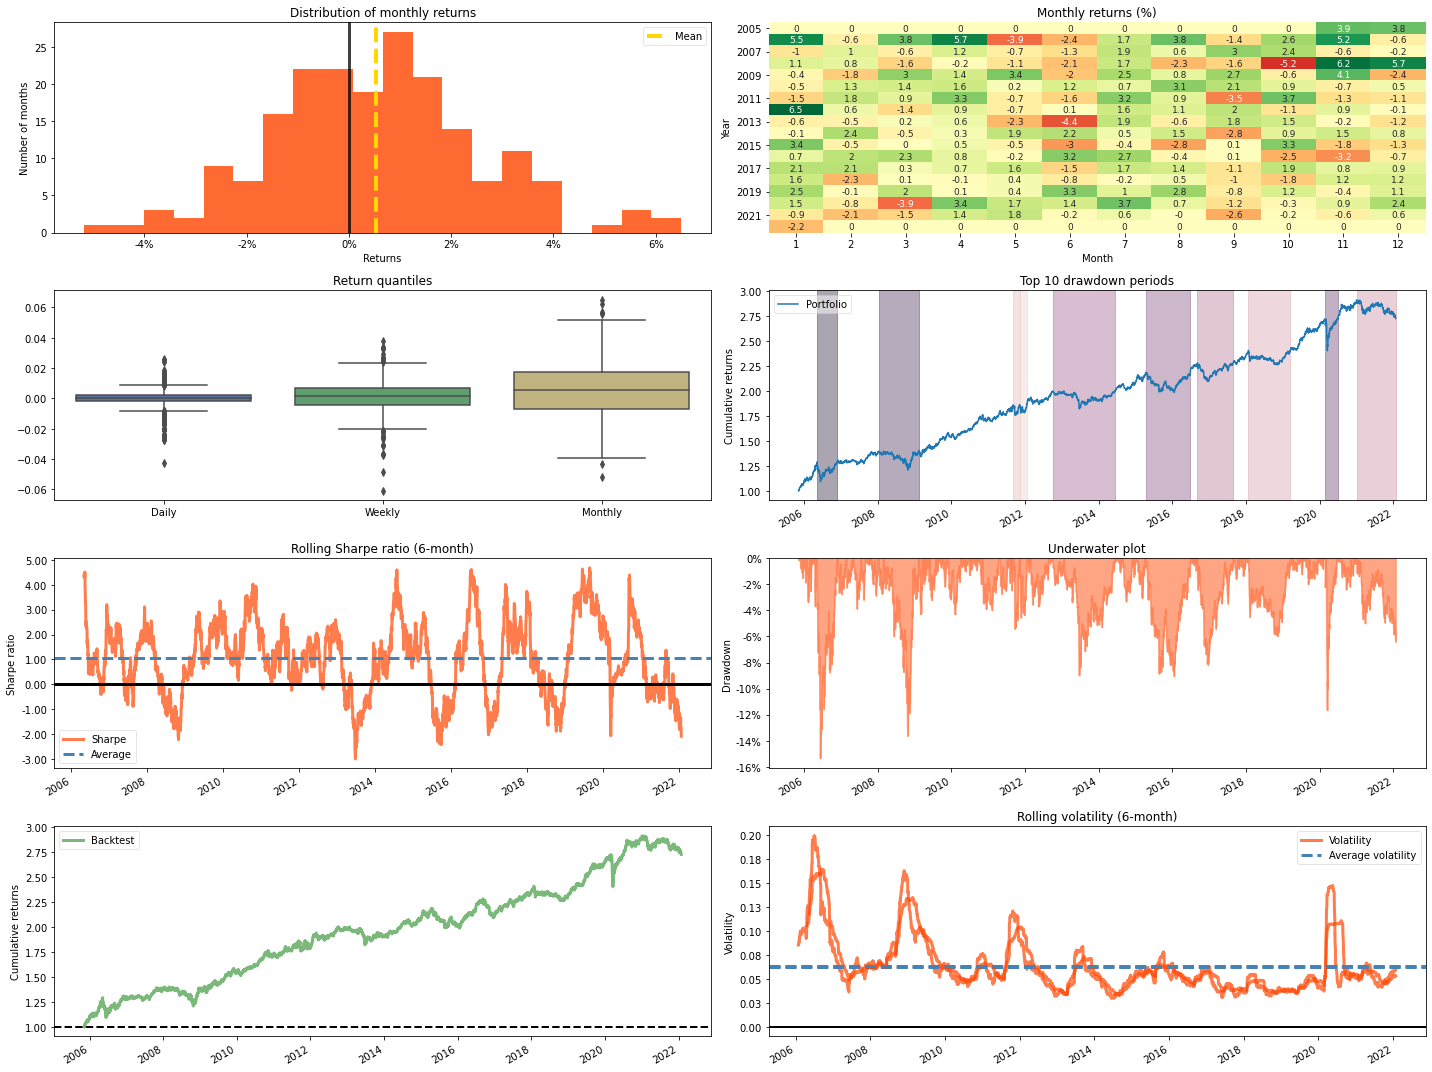

In [246]:
fig = plt.figure(1)
plt.rcParams['figure.figsize'] = [20, 15]
plt.subplot(4, 2, 1)
pf.plot_monthly_returns_dist(NAV_ret_perf)
plt.subplot(4, 2, 2)
pf.plot_monthly_returns_heatmap(NAV_ret_perf)
plt.subplot(4, 2, 3)
pf.plot_return_quantiles(NAV_ret_perf)
plt.subplot(4, 2, 4)
pf.plot_drawdown_periods(NAV_ret_perf)
plt.subplot(4, 2, 5)
pf.plot_rolling_sharpe(NAV_ret_perf)
plt.subplot(4, 2, 6)
pf.plot_drawdown_underwater(NAV_ret_perf)
plt.subplot(4,2,7)
pf.plot_rolling_returns(NAV_ret_perf)
plt.subplot(4, 2, 8)
pf.plot_rolling_volatility(NAV_ret_perf, rolling_window=60)
pf.plot_rolling_volatility(NAV_ret_perf, rolling_window=120)
plt.tight_layout()

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

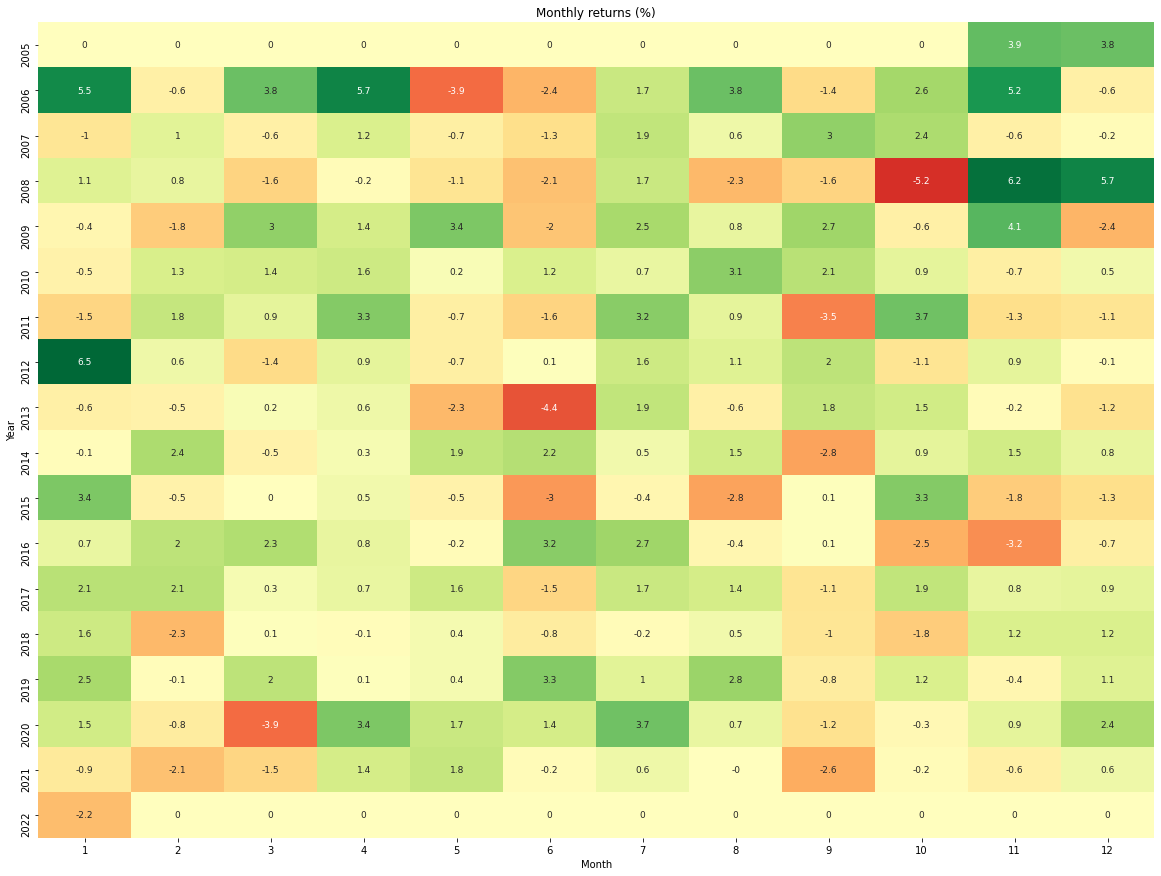

In [458]:
pf.plot_monthly_returns_heatmap(NAV_ret_perf)

### Test of normality, Autocorrelation and Aggregation

(3.531439157881567, 0.00038505299908823184, 0.002935287034036474)
(3.531439157881567, 0.00038505299908823184, 0.002935287034036474)
(3.531439157881567, 0.00038505299908823184, 0.002935287034036474)


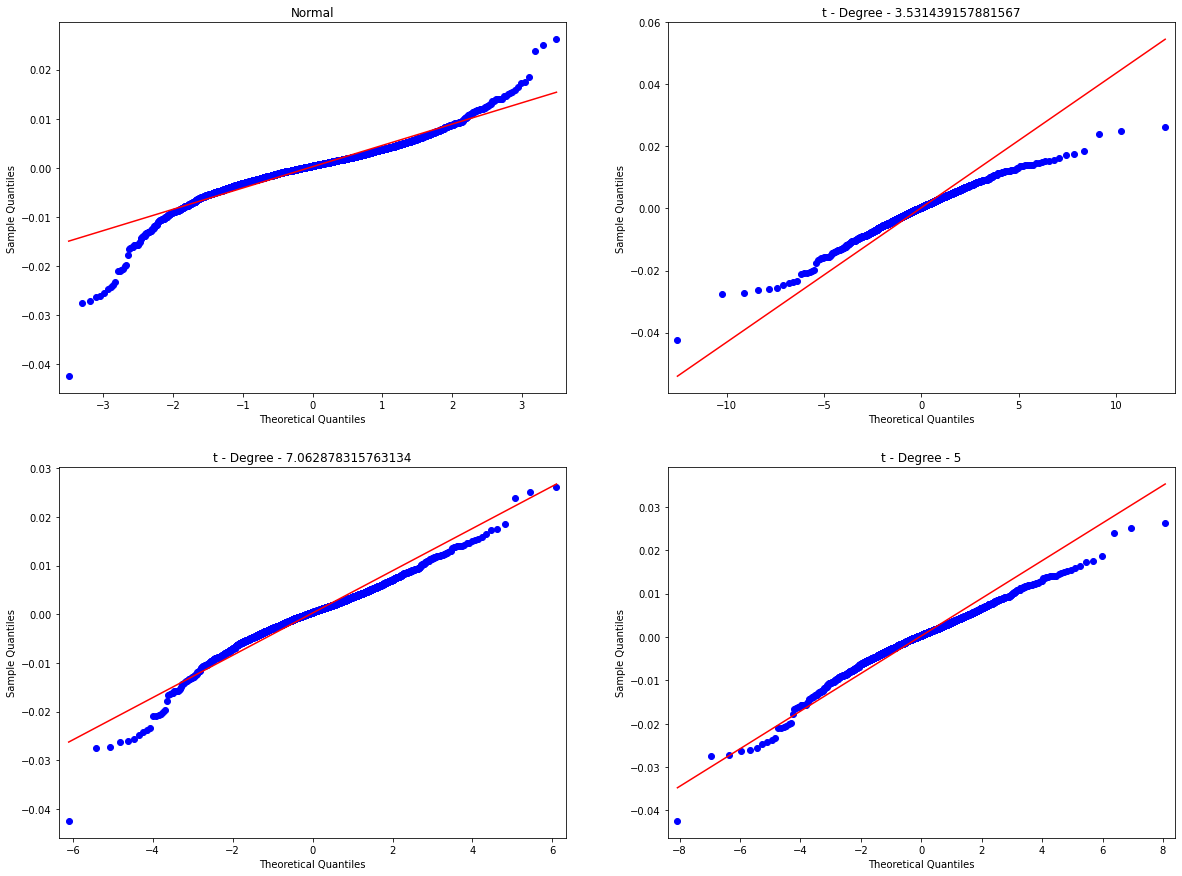

In [426]:
## Analysis of statistical properties of returns
## - Normality (dstribution, QQ plot vs. normal, t(2), t(3), t(4) ... t(10))
## - Kurtosis & Skew
## - tail behaviour 
## - Rolling analysis for regime dependence
## - ACF of daily, weekly and monthly returns
## - ACF of daily, weekly and monthly returns**2, returns**3, returns**4
## - check for stationarity overall + rolling basis
## - Aggregational Guassianity .. as returns are aagregated daily -> weekly -> monthly -> annual, central limit should kick in to make agg return gaussian, important to understand at what level does gaussianity kick in
## - Leverage Effect

# Q-Q Plot
import scipy.stats 
fig = plt.figure()

ax = plt.subplot(2, 2, 1)
qqplot(NAV_ret_perf, line="s", ax=ax)
ax.title.set_text("Normal")

ax = plt.subplot(2, 2, 2)
params = scipy.stats.t.fit(NAV_ret_perf.dropna())
print(params)
qqplot(NAV_ret_perf, line="s", dist=scipy.stats.t, distargs=(params[0],), ax=ax)
ax.title.set_text("t - Degree - %s" % params[0])

ax = plt.subplot(2, 2, 3)
params = scipy.stats.t.fit(NAV_ret_perf.dropna())
print(params)
qqplot(NAV_ret_perf, line="s", dist=scipy.stats.t, distargs=(params[0]*2,), ax=ax)
ax.title.set_text("t - Degree - %s" % (2*params[0]))

ax = plt.subplot(2, 2, 4)
params = scipy.stats.t.fit(NAV_ret_perf.dropna())
print(params)
qqplot(NAV_ret_perf, line="s", dist=scipy.stats.t, distargs=(5,), ax=ax)
ax.title.set_text("t - Degree - %s" % (5))

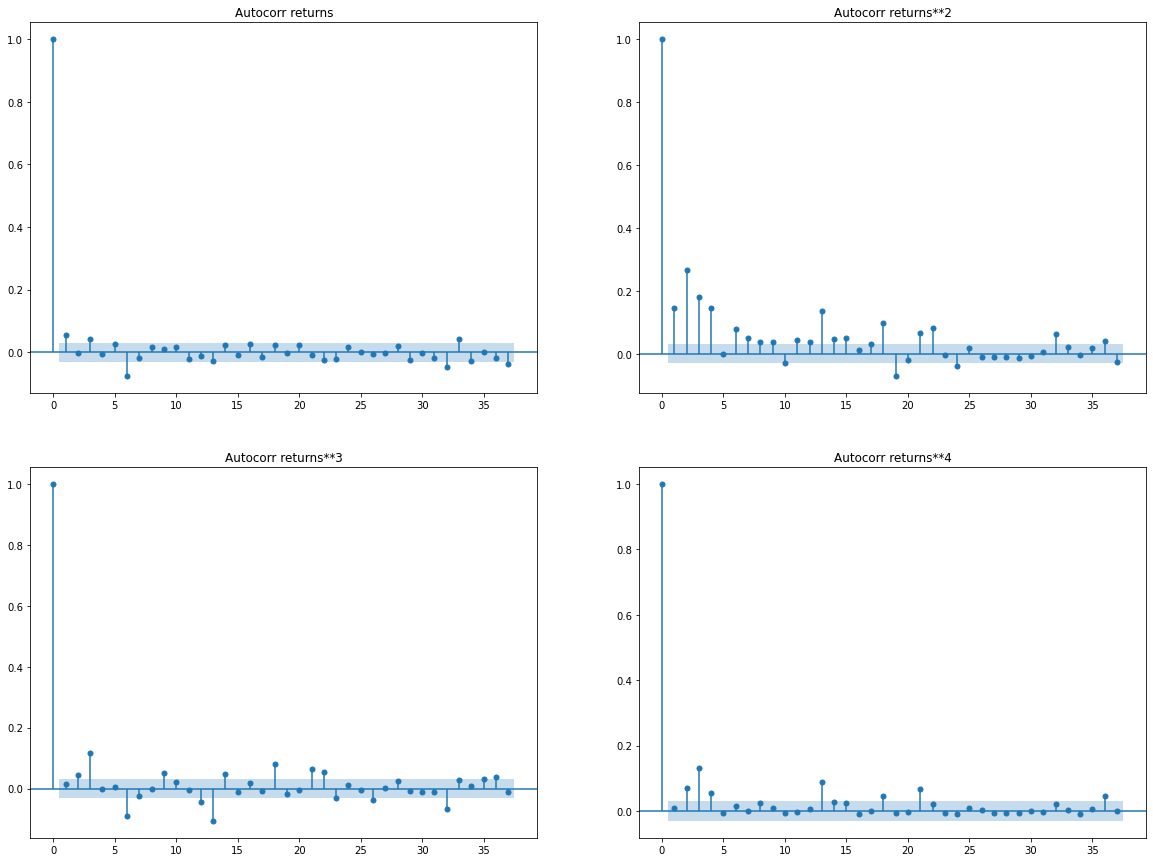

In [430]:
# ACF plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()

ax = plt.subplot(2, 2, 1)
plot_pacf(NAV_ret_perf, ax=ax)
ax.title.set_text("Autocorr returns")

ax = plt.subplot(2, 2, 2)
plot_pacf(NAV_ret_perf**2, ax=ax)
ax.title.set_text("Autocorr returns**2")

ax = plt.subplot(2, 2, 3)
plot_pacf(NAV_ret_perf**3, ax=ax)
ax.title.set_text("Autocorr returns**3")

ax = plt.subplot(2, 2, 4)
plot_pacf(NAV_ret_perf**4, ax=ax)
ax.title.set_text("Autocorr returns**4")

847
195
66


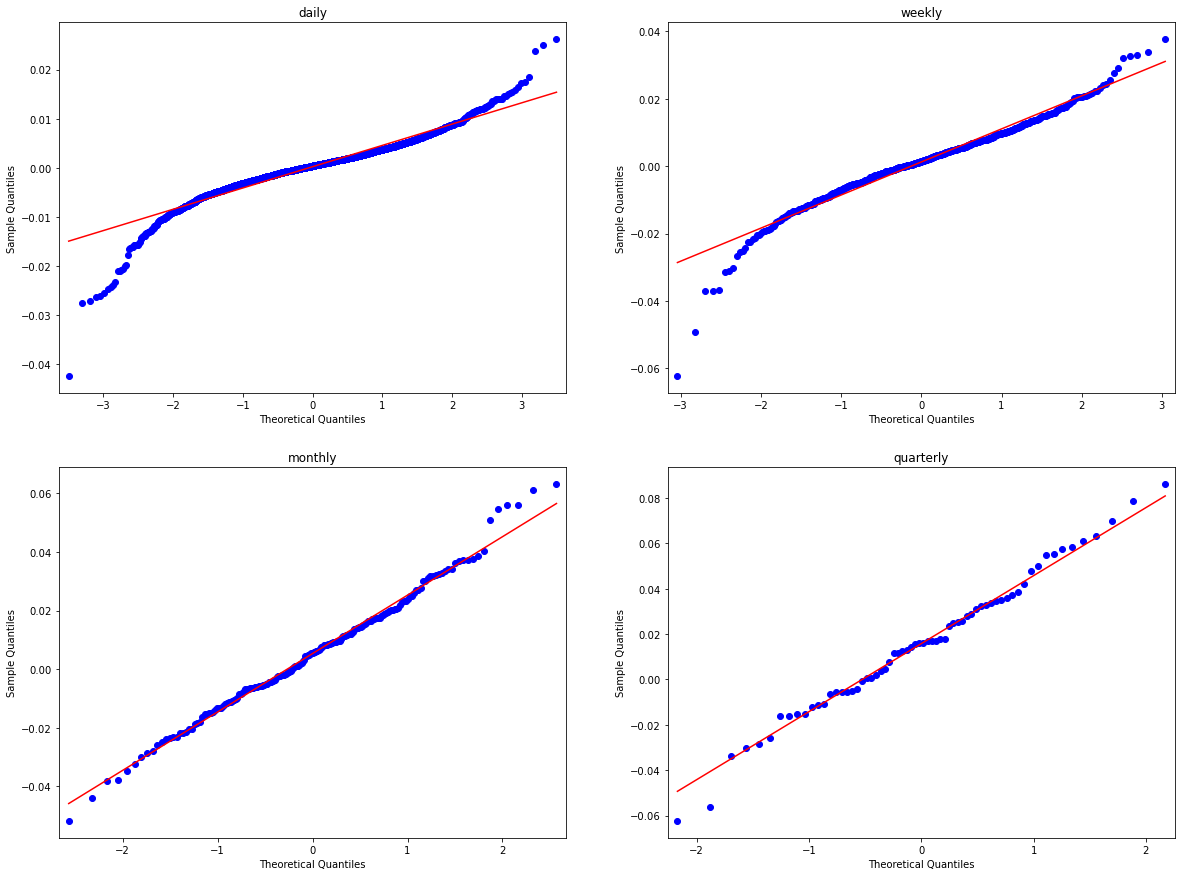

In [442]:
# Time Aggregation 

fig = plt.figure()
ax = plt.subplot(2, 2, 1)
qqplot(NAV_ret_perf, line="s", ax=ax)
ax.title.set_text("daily")

ax = plt.subplot(2, 2, 2)
weekly_ret = NAV_ret_perf.resample('1w').sum()
print(len(weekly_ret))
qqplot(weekly_ret, line="s", ax=ax)
ax.title.set_text("weekly")

ax = plt.subplot(2, 2, 3)
weekly_ret = NAV_ret_perf.resample('1m').sum()
print(len(weekly_ret))
qqplot(weekly_ret, line="s", ax=ax)
ax.title.set_text("monthly")

ax = plt.subplot(2, 2, 4)
weekly_ret = NAV_ret_perf.resample('3m').sum()
print(len(weekly_ret))
qqplot(weekly_ret, line="s", ax=ax)
ax.title.set_text("quarterly")

### Analysis of Monthly Returns

ShapiroResult(statistic=0.9927840828895569, pvalue=0.45271527767181396)

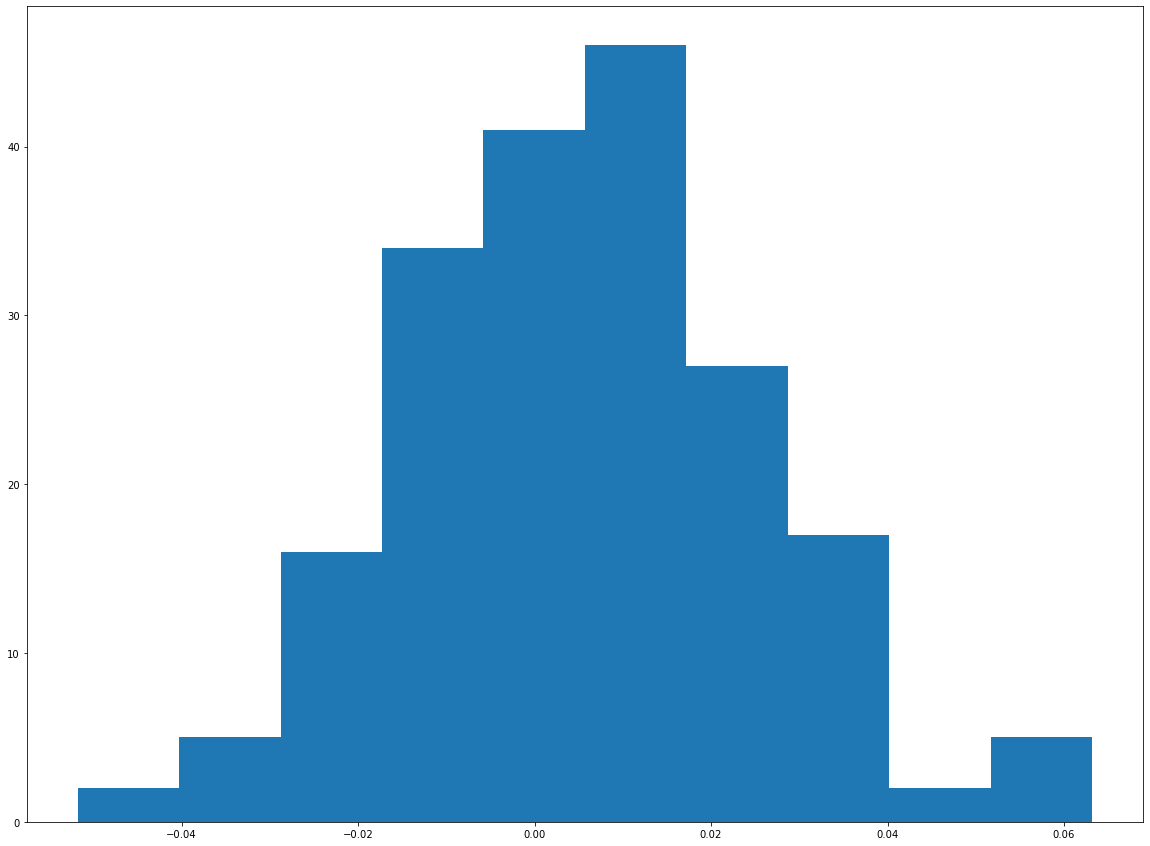

In [459]:
weekly_ret = NAV_ret_perf.resample('1m').sum()
plt.hist(weekly_ret)
scipy.stats.jarque_bera(weekly_ret)
scipy.stats.shapiro(weekly_ret)

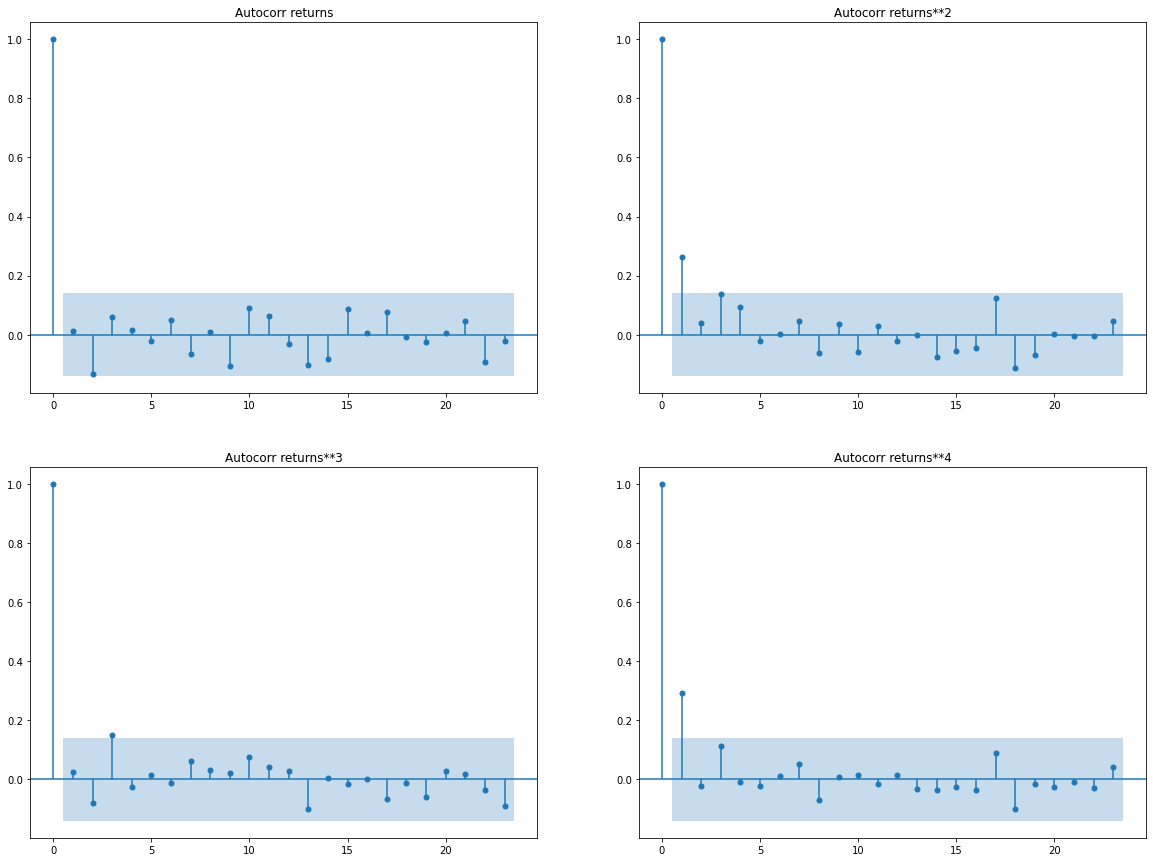

In [460]:
fig = plt.figure()

ax = plt.subplot(2, 2, 1)
plot_pacf(weekly_ret, ax=ax)
ax.title.set_text("Autocorr returns")

ax = plt.subplot(2, 2, 2)
plot_pacf(weekly_ret**2, ax=ax)
ax.title.set_text("Autocorr returns**2")

ax = plt.subplot(2, 2, 3)
plot_pacf(weekly_ret**3, ax=ax)
ax.title.set_text("Autocorr returns**3")

ax = plt.subplot(2, 2, 4)
plot_pacf(weekly_ret**4, ax=ax)
ax.title.set_text("Autocorr returns**4")

In [464]:
# Check the equivalence of the monthly returns computed as an aggregation of daily returns or computed from the wealth time series
monthly_vals = (100 * (1 + NAV_ret_perf).cumprod()).resample('1m').last()
monthly_rets = monthly_vals.pct_change()
monthly_rets[0] = monthly_vals[0] / 100 - 1
weekly_ret = NAV_ret_perf.resample('1m').sum()
monthly_ret_df = pd.DataFrame({'agg_daily': weekly_ret, 'cumprod_monthly': monthly_rets})
(monthly_ret_df+1).cumprod(axis=0) *100

agg_daily  cumprod_monthly
2005-11-30  103.870637       103.928922
2005-12-31  107.756136       107.864895
2006-01-31  113.637423       113.849033
2006-02-28  112.977135       113.144301
2006-03-31  117.193657       117.397984
...                ...              ...
2021-09-30  279.181647       279.543382
2021-10-31  278.593890       278.925825
2021-11-30  276.973488       277.262620
2021-12-31  278.536367       278.795826
2022-01-31  272.469817       272.751979

[195 rows x 2 columns]

(0.06420888490890542, 0.06922141951883419, 0.9275869428166678)

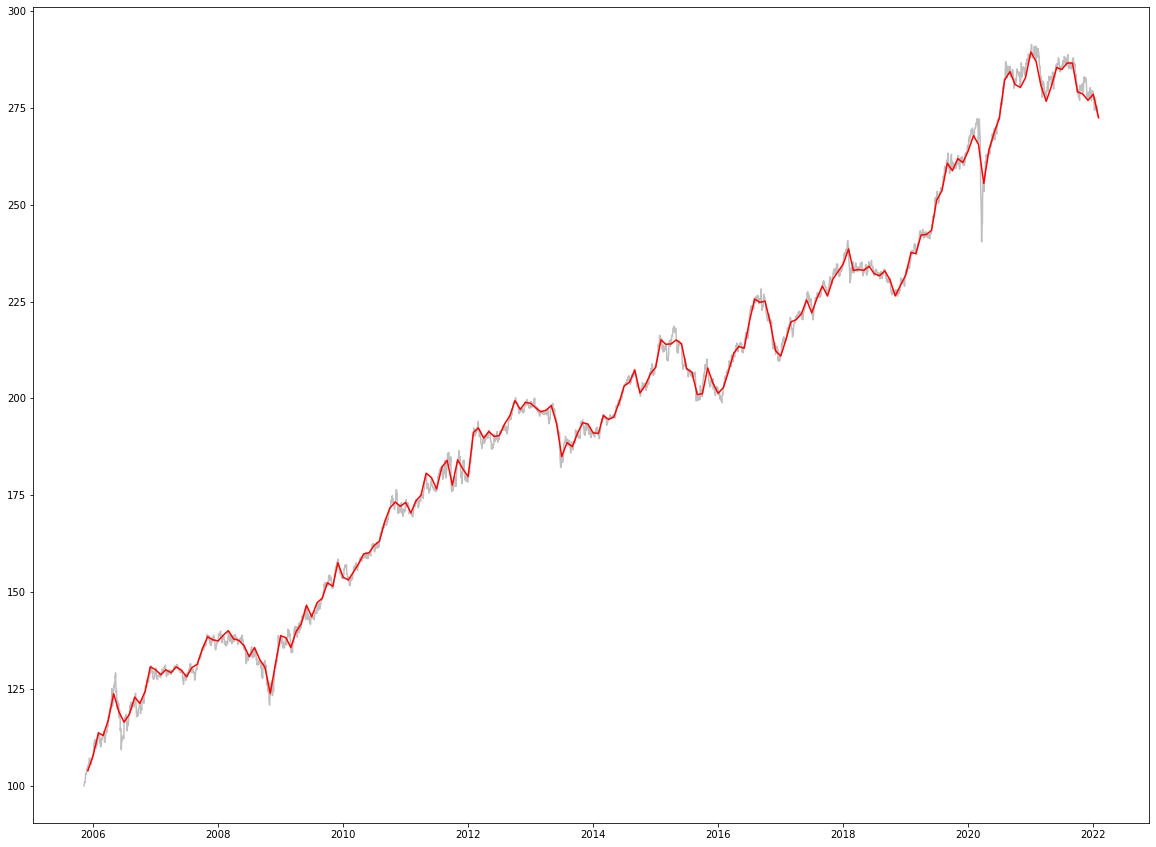

In [468]:
# Stats based on monthly returns
monthly_ret = NAV_ret_perf.resample('1m').sum()
ann_ret = monthly_ret.mean() * 12
ann_vol = monthly_ret.std() * np.sqrt(12)
sharpe_ratio = ann_ret / ann_vol
wealth = 100 * (1 + monthly_ret).cumprod()
plt.plot(100 * (1 + NAV_ret_perf).cumprod(), color='gray', alpha=0.5)
plt.plot(wealth, color='red')
ann_ret, ann_vol, sharpe_ratio

### Volatility measures and Drawdown

mu          0.029873
omega       0.001798
alpha[1]    0.058690
beta[1]     0.930547
nu          7.449903
Name: params, dtype: float64


<AxesSubplot:>

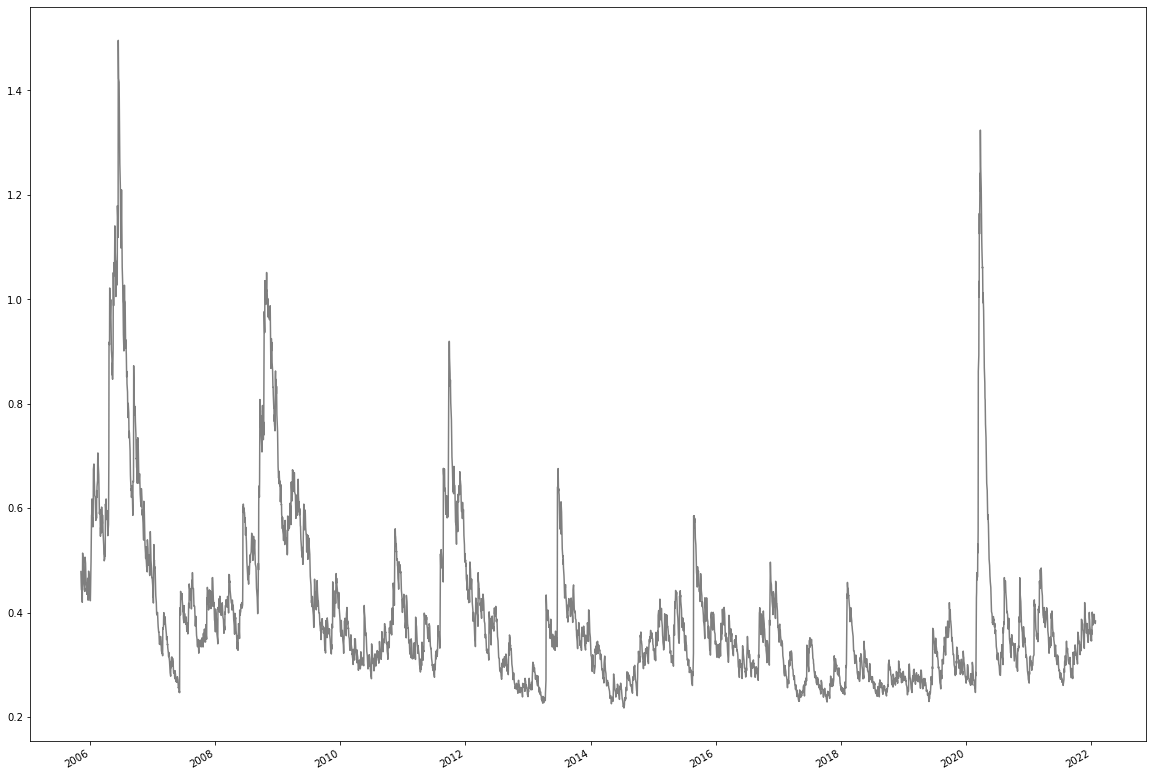

In [549]:
## ARCH and Volatility modelling
from arch import arch_model
import scipy.stats as stats

am = arch_model(NAV_ret_perf.fillna(0)*100, p=1, q=1, o=0, dist="StudentsT")
res = am.fit(update_freq=5, disp="off")
# print(res.summary())
# res.plot()
# Time Series of Conditional Volatility
theo_vol = res.conditional_volatility
forecast = np.sqrt(res.params['omega'] + res.params['alpha[1]'] * NAV_ret_perf**2 + res.params['beta[1]'] * theo_vol**2)
forecast2 = np.sqrt(res.params['omega'] + (res.params['alpha[1]'] + res.params['beta[1]']) * forecast**2)
# params
print(res.params)
# residuals
# res.resid
# print(res.pvalues)

# qqplot(res.resid, stats.t, distargs=(3.5,), line="q")
# res.plot()

# res.params['mu']
# forecasts = res.forecast(horizon=500, method="simulation", reindex=False)
# sims = forecasts.simulations
# np.mean(np.mean(sims.variances[0,:,-300:], axis=1))
theo_vol.plot(color='black', alpha=0.5)
# forecast2.plot(color='red')

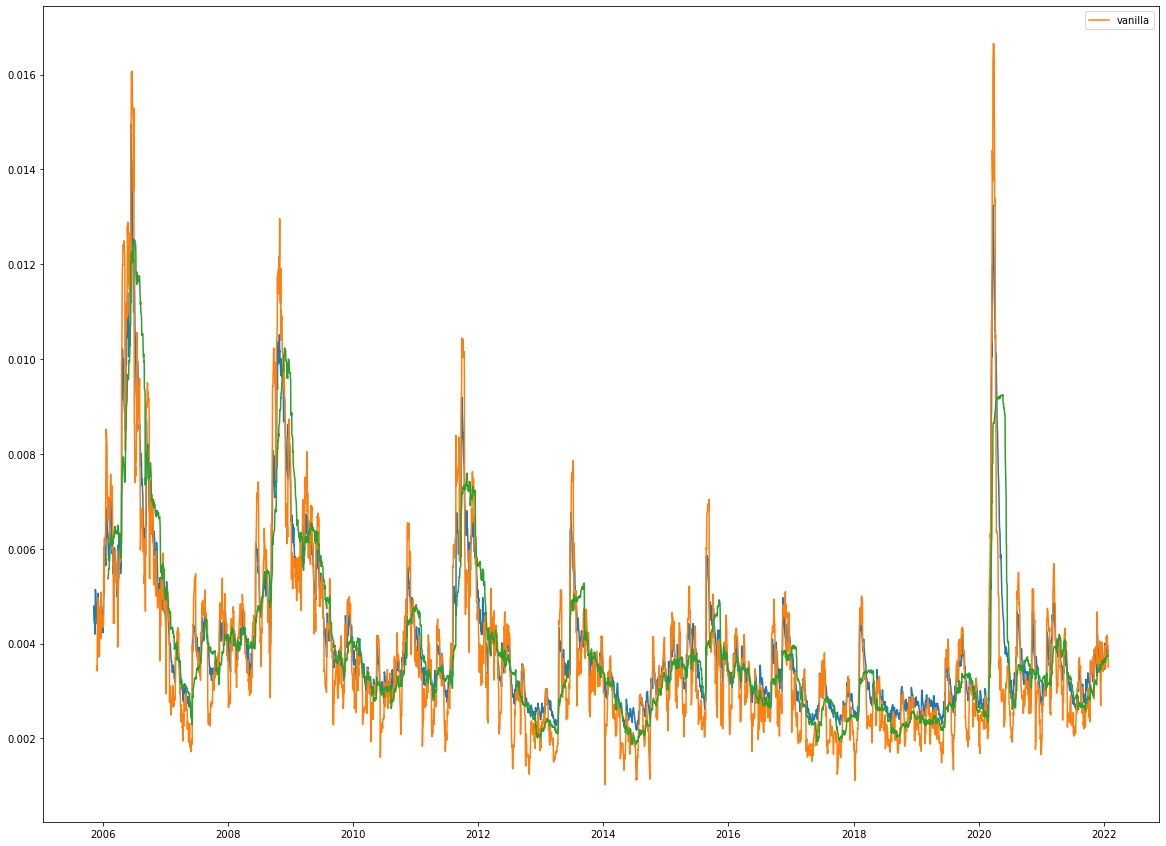

In [551]:
# Measures of Volatility

# backward looking volatility measure for benchmarking
# theo_vol = NAV_ret_perf.rolling(20, center=True).std()
vol_1m = NAV_ret_perf.rolling(14).std()
vol_3m = NAV_ret_perf.rolling(60).std()
vol_1m_exp = np.sqrt((NAV_ret_perf**2).ewm(span=20).mean())
vol_3m_exp = np.sqrt((NAV_ret_perf**2).ewm(span=30).mean())
# vol_hull = np.sqrt((2*((NAV_ret_perf**2).ewm(span=18).mean()) - (NAV_ret_perf**2).ewm(span=36).mean()).ewm(span=6).mean())
plt.plot(theo_vol/100, label="theoretical", color='red')
plt.plot(vol_1m, label='vanilla_1M')
plt.plot(vol_3m, label='vanilla_3M')
# plt.plot(vol_1m_exp, label='exponential')
# plt.plot(vol_3m_exp, label='hull')
def compute_aligned_corr(x, y, shift):
    df = pd.DataFrame({'X': x, 'Y': y.shift(shift)})
    df = df.dropna()
    return np.sum((df['X']- df['Y'])**2)
shifted_vals = [compute_aligned_corr(theo_vol, vol_hull, i) for i in range(-60, 60)]
# plt.plot(range(-60, 60), shifted_vals)
# plt.plot(range(-60, 60), shifted_vals)
# plt.axvline(-10)
# plt.axvline(10)
# plt.xticks(np.arange(-60, 60, step=10))
plt.legend(loc=0)
# plt.xlim((date(2011,1,1), date(2016,1,1)))

0.06190181766668805 0.06887235101698286 0.068569312219568


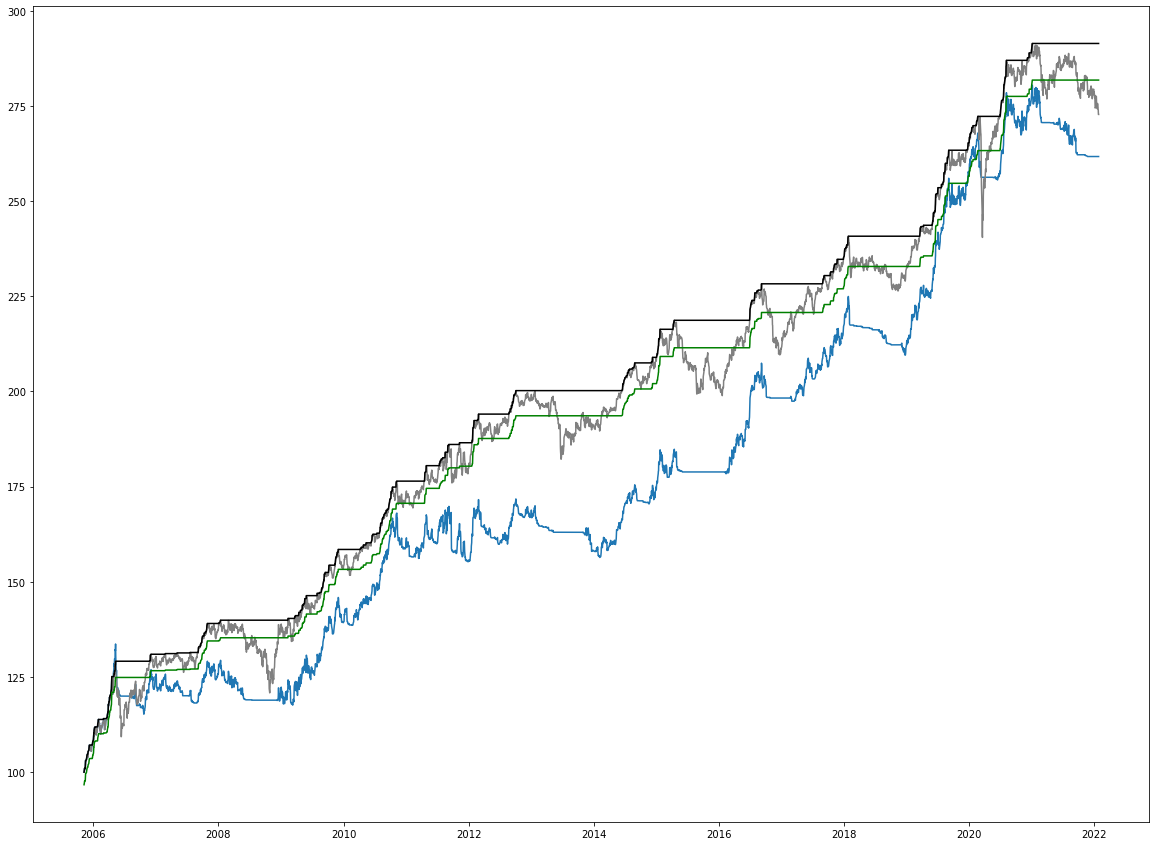

In [540]:
pos = (0.06 /(vol_1m_exp * np.sqrt(252))).clip(upper=1.5)
scaled_ret = pos.shift(1).fillna(1) * NAV_ret_perf
scaled_wealth = (1+scaled_ret).cumprod()*100
scaled_max = scaled_wealth.rolling(120).max()
drawdown = 1 - scaled_wealth / scaled_max
dd_max = 0.033
dd_to_use = drawdown.copy()
dd_to_use[dd_to_use<0.02]=0
drawdown_scale = (1 / dd_max * (dd_max - dd_to_use) / (1 - dd_to_use)).clip(lower=0)
combined_scale = drawdown_scale * 1.5
comb_ret = combined_scale.shift(1).fillna(1) * NAV_ret_perf
comb_wealth = (1 + comb_ret).cumprod()*100
print(scaled_ret.std() * np.sqrt(252), NAV_ret_perf.std()*np.sqrt(252), comb_ret.std() * np.sqrt(252))
# plt.plot(scaled_wealth, color='red')
raw_wealth = (1+NAV_ret_perf).cumprod()*100
max_raw_wealth = raw_wealth.cummax()
raw_dd = 1 - raw_wealth / raw_wealth.cummax()
plt.plot(comb_wealth)
plt.plot(raw_wealth, color='grey')
plt.plot(max_raw_wealth, color='black')
plt.plot((1-dd_max)*max_raw_wealth, color='green')
# plt.plot(drawdown_scale)


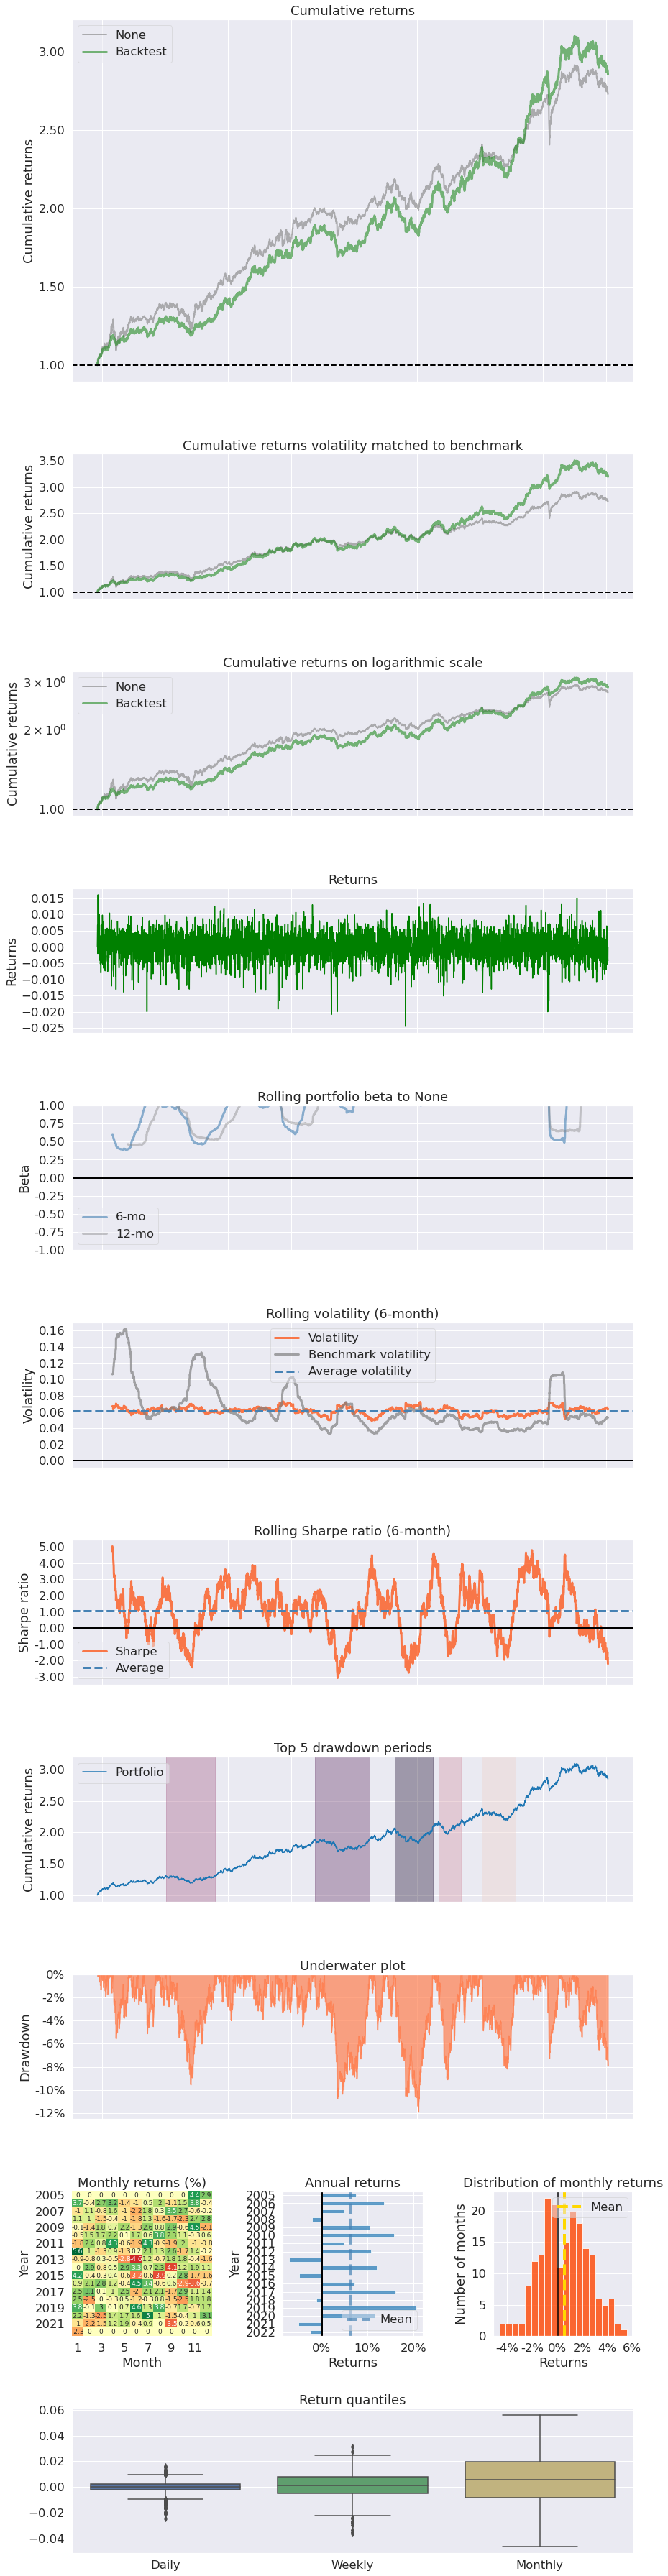

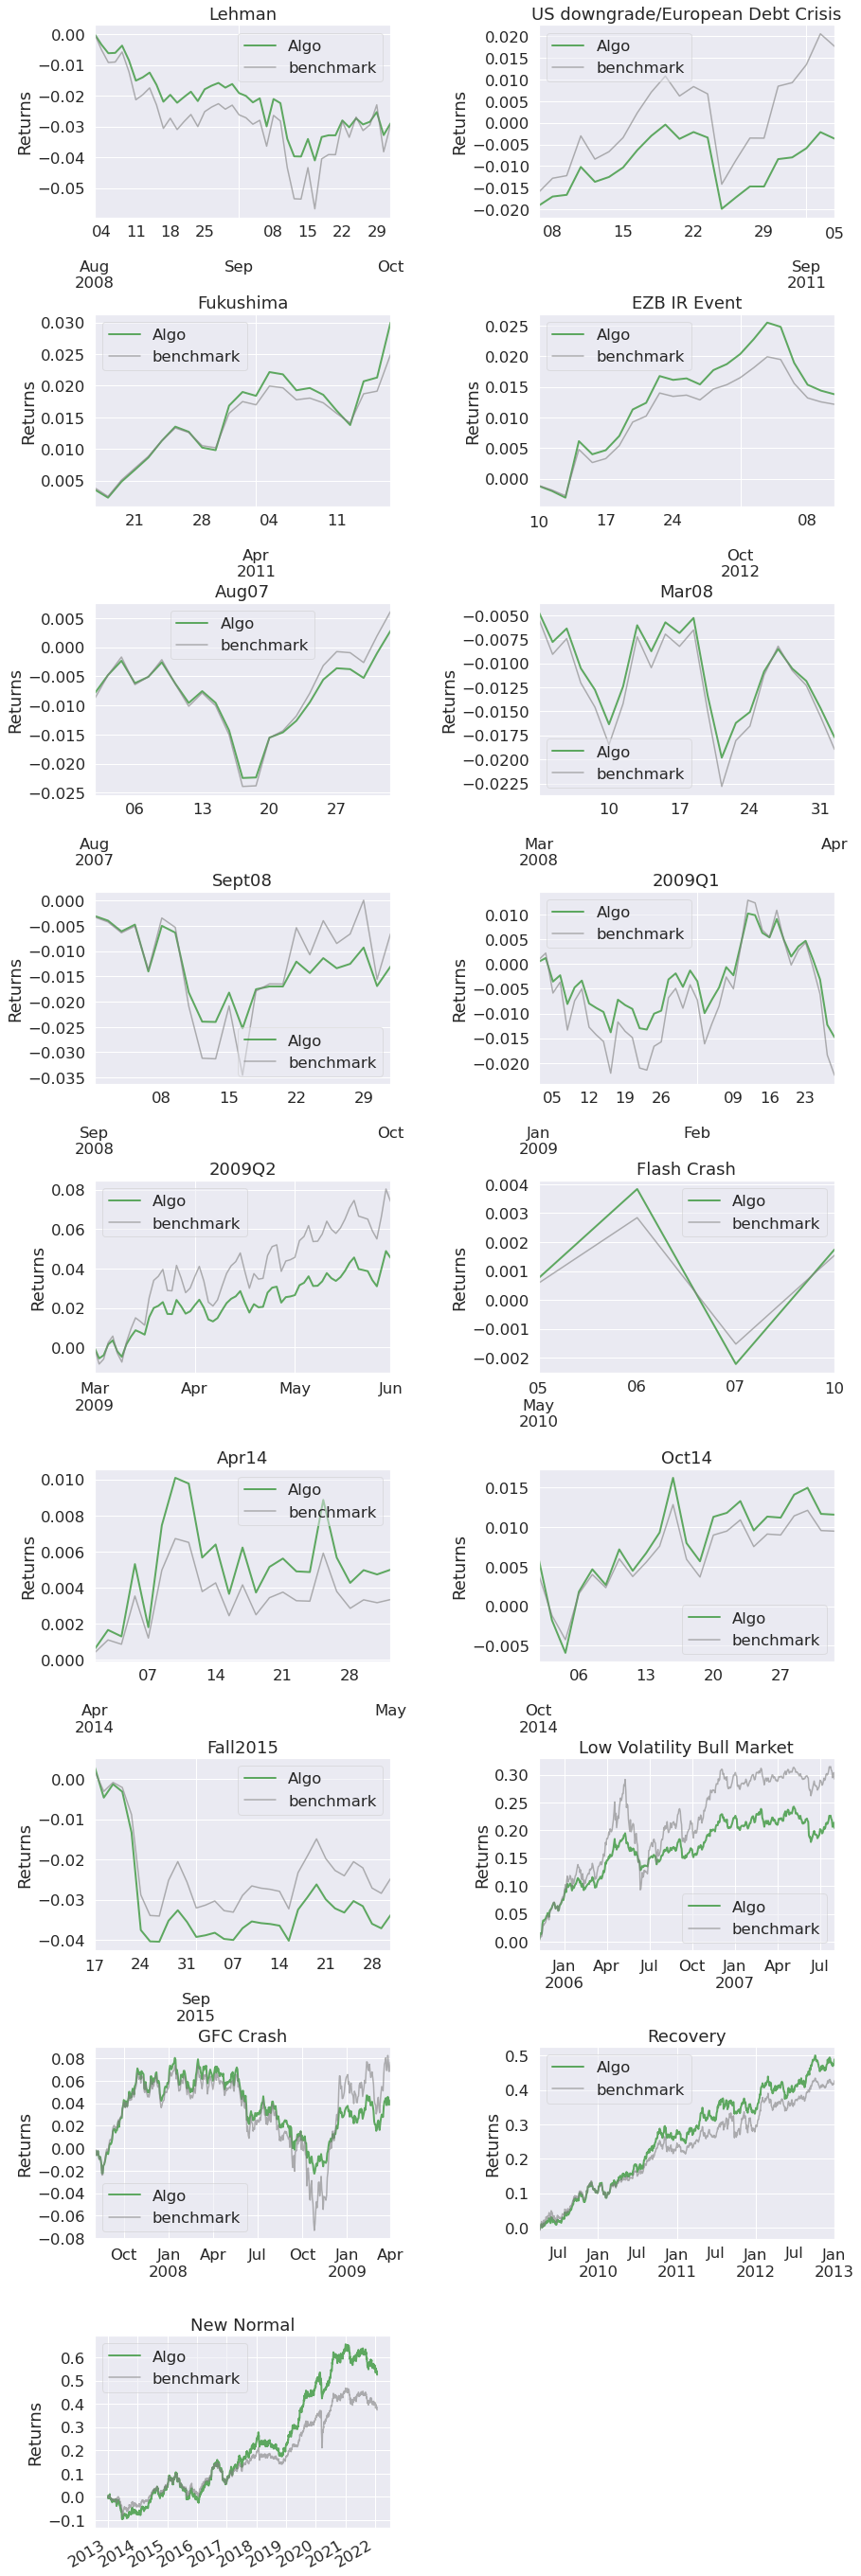

In [526]:
pf.create_full_tear_sheet(scaled_ret, benchmark_rets=NAV_ret_perf)

OrderedDict([('Dotcom',
              (Timestamp('2000-03-10 00:00:00'),
               Timestamp('2000-09-10 00:00:00'))),
             ('Lehman',
              (Timestamp('2008-08-01 00:00:00'),
               Timestamp('2008-10-01 00:00:00'))),
             ('9/11',
              (Timestamp('2001-09-11 00:00:00'),
               Timestamp('2001-10-11 00:00:00'))),
             ('US downgrade/European Debt Crisis',
              (Timestamp('2011-08-05 00:00:00'),
               Timestamp('2011-09-05 00:00:00'))),
             ('Fukushima',
              (Timestamp('2011-03-16 00:00:00'),
               Timestamp('2011-04-16 00:00:00'))),
             ('US Housing',
              (Timestamp('2003-01-08 00:00:00'),
               Timestamp('2003-02-08 00:00:00'))),
             ('EZB IR Event',
              (Timestamp('2012-09-10 00:00:00'),
               Timestamp('2012-10-10 00:00:00'))),
             ('Aug07',
              (Timestamp('2007-08-01 00:00:00'),
               Timesta

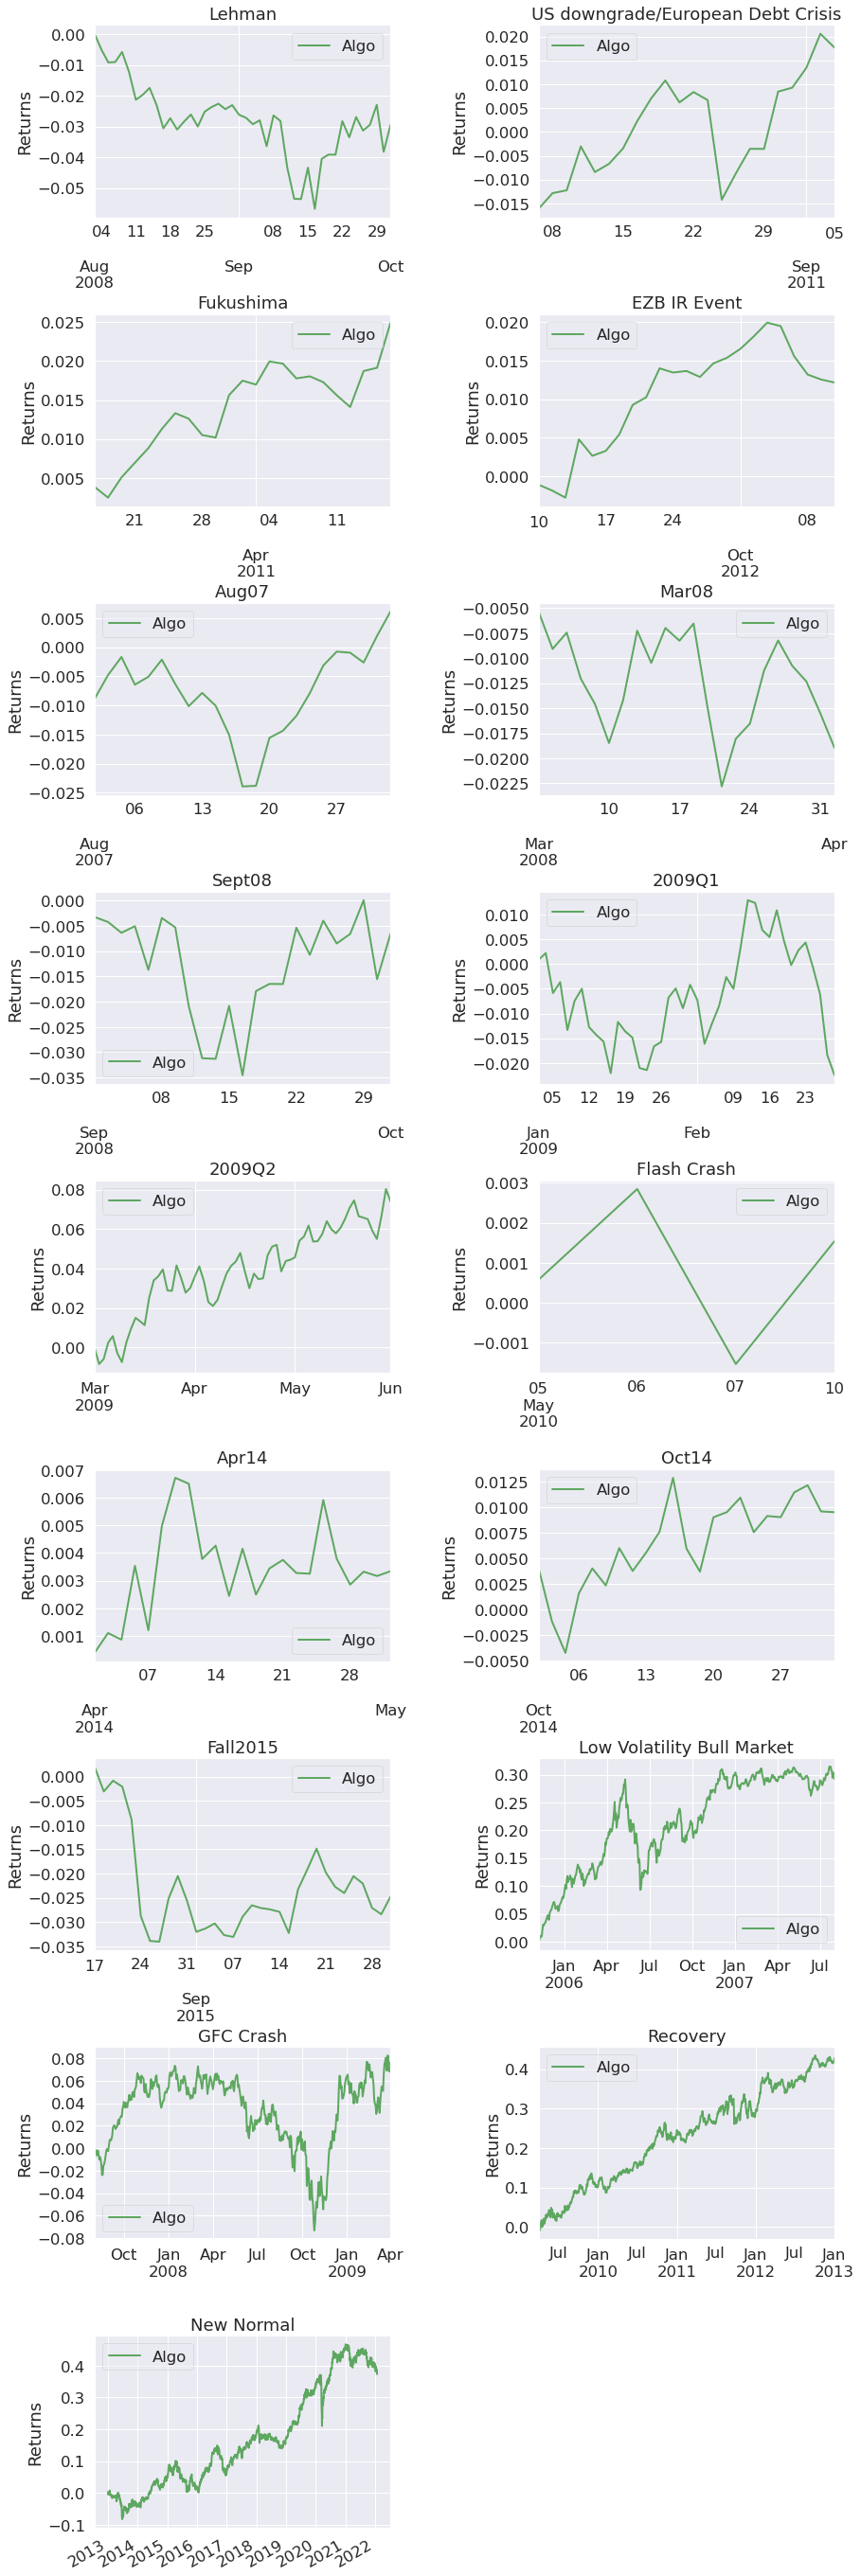

In [471]:
# Measures of Drawdown
pf.create_interesting_times_tear_sheet(NAV_ret_perf)
pf.interesting_periods.PERIODS

## Volatility Targetting

In [ ]:
## ARCH and Volatility modelling
from arch import arch_model
import scipy.stats as stats

am = arch_model(NAV_ret_perf.fillna(0)*100, p=1, q=1, o=0, dist="StudentsT")
res = am.fit(update_freq=5, disp="off")
# print(res.summary())
# res.plot()
# Time Series of Conditional Volatility
res.conditional_volatility
# params
print(res.params)
# residuals
# res.resid
# print(res.pvalues)

# qqplot(res.resid, stats.t, distargs=(3.5,), line="q")
# res.plot()

# res.params['mu']
forecasts = res.forecast(horizon=500, method="simulation", reindex=False)
sims = forecasts.simulations
np.mean(np.mean(sims.variances[0,:,-300:], axis=1))

In [ ]:
class ARCH_VOl_TARGET:
    def __init__(self, hist_window, p=1, q=1, o=0, power=2, min_hist_window=None, rebal_window=20):
        self.hist_window = hist_window
        self.min_hist_window = min_hist_window if min_hist_window is not None else hist_window
        self.rebal_window = rebal_window

        self.calib_data = []
        self.hist_data = []
        self.pos_scale = []
        self.num_days_since_calib = 0

        self.model_params = (p, q, o, power)
        self.model = None
        self.model_params = None

    def add_datum(self, ret):
        self.hist_window.append(ret)
        if len(self.hist_window)>=self.hist_window:
            if self.num_days_since_calib==0 or self.num_days_since_calib==self.rebal_window:
                if self.model is None:
                    self.model = arch_model()
                
            else:
                pass
        elif len(self.hist_window)>=self.min_hist_window:
            if self.num_days_since_calib==0 or self.num_days_since_calib==self.rebal_window:
                pass
            else:
                pass
        else:
            pass

In [ ]:
class ArchModel:
    def __init__(self, data, p=1, q=1, o=1, power=2, dist="StudentsT", starting_values=None):
        am = arch_model(x*scale, p=1, q=1, o=0, dist="StudentsT")
        

In [415]:
scale = 100
window = 120
calib_freq = 60
real_vol_alpha = 0.2

def apply_arch_vol_target(x, ann_target_perc, starting_values):
    target = ann_target_perc / np.sqrt(252)
    am = arch_model(x*scale, p=1, q=1, o=0, dist="StudentsT")
    if starting_values is not None:
        res = am.fit(update_freq=5, disp="off", starting_values=starting_values, show_warning=False)
    else:
        res = am.fit(update_freq=5, disp="off", show_warning=False)
    params = res.params
    conditional_volatility = res.conditional_volatility[-1]
    forecasts = res.forecast(horizon=500, method="simulation", reindex=False)
    sims = forecasts.simulations
    # Compute max target vol for sharpe 
    sim_var = sims.variances[0,:,-300:]
    sim_vol = np.sqrt(sim_var)
    mean_sigma = np.mean(np.mean(sim_var, axis=1))
    mean_sigma_inv = np.mean(np.mean(1 / sim_vol, axis=1))
    target_max = mean_sigma**2 * mean_sigma_inv
    if target_max < target:
        target = target_max
    # Comp
    root_mean_inv_var = np.sqrt(np.mean(np.mean(1 / sim_var, axis=1)))
    pos_scale = target / root_mean_inv_var *(1 / conditional_volatility**2)
    # results compilation
    results = dict()
    results['mu'] = params['mu']
    results['omega'] = params['omega']
    results['alpha'] = params['alpha[1]']
    results['beta'] = params['beta[1]']
    results['nu'] = params['nu']
    results['conditional_vol'] = conditional_volatility
    results['long_term_vol'] = mean_sigma
    results['mean_inv_sigma'] = mean_sigma_inv
    results['root_mean_inv_var'] = root_mean_inv_var
    results['target'] = target
    results['target_max'] = target_max
    results['pos_scale'] = pos_scale
    return pd.Series(results)

ann_target_perc = 6
result_df = dict()
# vol_target_pos = NAV_ret_perf.rolling(120).apply(lambda x: apply_arch_vol_target(x[~np.isnan(x)], ann_target_perc))
# plt.plot(vol_target_pos)
starting_values = None
prev_calib_results = None
num_days_since_calib = 0
for w in NAV_ret_perf.rolling(window):
    if len(w)<window:
        result_df[w.index[-1]] = pd.Series()
    else:
        if starting_values is None or num_days_since_calib >= calib_freq:
            d = apply_arch_vol_target(w.values, ann_target_perc, None)
            d['realized_vol'] = np.std(w.values * scale)
            if len(result_df) > 0:
                d['exp_vol'] = np.sqrt(real_vol_alpha * result_df[w.index[-2]]['exp_vol']**2 + (1-real_vol_alpha) * w[-1]**2 * scale**2)
            else:
                d['exp_vol'] = d['realized_vol']
            result_df[w.index[-1]] = d
            # Store
            starting_values = (d['mu'], d['omega'], d['alpha'], d['beta'], d['nu'])
            prev_calib_results = d
            num_days_since_calib = 0
            # Status
            print("Calib Done ...", w.index[-1])
        else:
            num_days_since_calib = num_days_since_calib + 1
            prev_params = prev_calib_results
            conditional_var = prev_params['omega'] + prev_params['alpha'] * w[-1]**2*scale**2 + prev_params['beta'] * prev_params['conditional_vol']**2
            vol = np.std(w.values * scale)
            d = prev_params.copy()
            d['conditional_vol'] = np.sqrt(conditional_var)
            d['realized_vol'] = vol
            if len(result_df) > 0:
                d['exp_vol'] = np.sqrt(real_vol_alpha * result_df[w.index[-2]]['exp_vol']**2 + (1-real_vol_alpha) * w[-1]**2 * scale**2)
            else:
                d['exp_vol'] = d['realized_vol']
            result_df[w.index[-1]] = d

result_df = pd.DataFrame(result_df).T

C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


KeyError: 'exp_vol'

In [416]:
plt.plot(result_df['realized_vol'])
plt.plot(result_df['exp_vol'])
plt.plot(result_df['conditional_vol'])
plt.plot(result_df['conditional_vol'].ewm(span=20).mean())
# plt.plot(result_df['alpha'] + result_df['beta'])

# plt.plot(result_df['target_max'])
# plt.axhline(0.07/np.sqrt(252))
# plt.ylim(0, 0.1)

# plt.plot(result_df['pos_scale'])

KeyError: 'realized_vol'

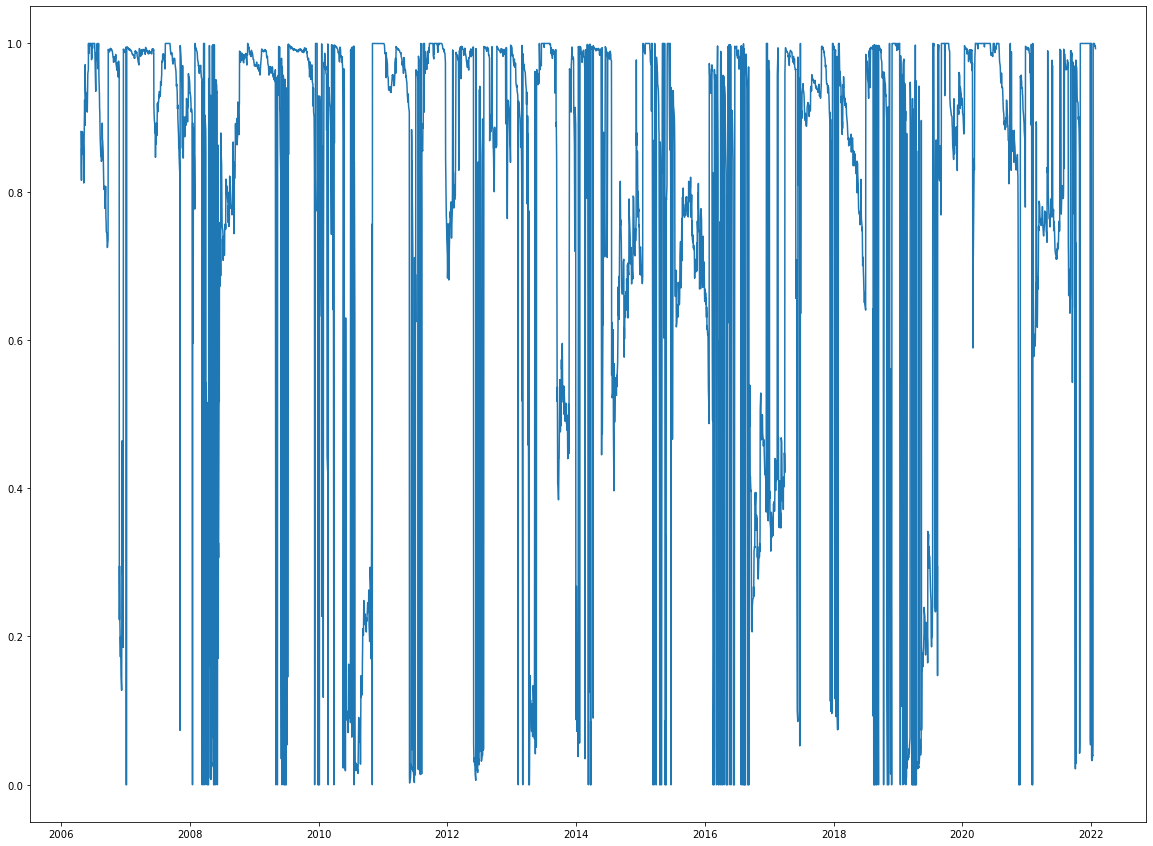

In [391]:
# plt.plot(result_df['realized_vol'])
# plt.plot(result_df['conditional_vol'])
# plt.plot(result_df['alpha'] + result_df['beta'])

# Exponential Volatility


## Drawdown heding using Option like positioning

C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\troy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


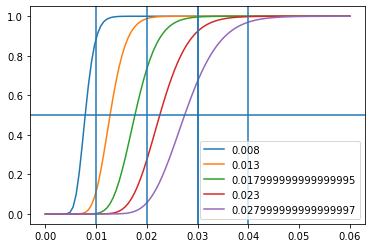

In [170]:
from scipy.stats import norm
from scipy.optimize import root, minimize

delta_func = lambda S, K, vol: norm.cdf(1/vol * (np.log(S/K) + vol**2/2))
dd_limit_low = 0.01
dd_limit_high = 0.03
delta_score = lambda x: ((0 - delta_func(0.01, x[0], x[1]))**2 + (0.99 - delta_func(0.05, x[0], x[1]))**2)*10000

x0 = [(dd_limit_low+dd_limit_high)/2, (dd_limit_high - dd_limit_low)*10]
delta_score(x0)
S = np.linspace(0, 2*dd_limit_high, 100)
K = np.linspace(dd_limit_low, dd_limit_high, 5)-0.002

for k in K:
    deltas = [delta_func(s, k, x0[1]) for s in S]
    plt.plot(S, deltas,label=k)
    
plt.axvline(dd_limit_high)
plt.axvline(0.03)
plt.axvline(0.02)
plt.axvline(0.01)
plt.axvline(0.04)
plt.axhline(0.5)
plt.legend(loc=0)

## Assets and Asset Time Series

0.23672131147540976 0.2865198156426531 0.8261952526545252 7.721120666939648


<AxesSubplot:>

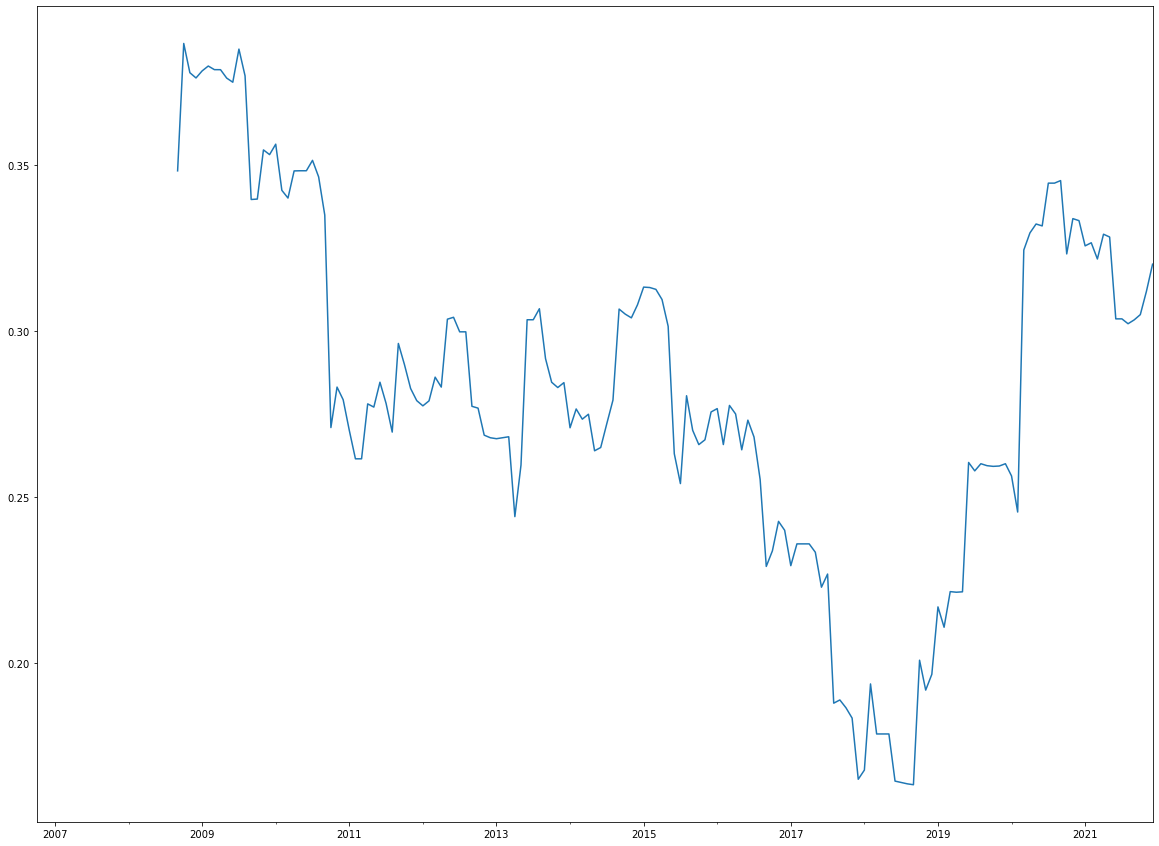

In [574]:
returns = [7, 14, 12,
           2, -1, -6, -1, 6, 4, -10, -16, 27, 11, 0, 7,
           2, 14, -6, 0, -1, 5, -7, -7, -17, -23, 8, 11,
           -6, -5, 4, 1, 0, 0, 16, 15, 13, -9, 15, -3,
           -6, 2, 3, 11, 3, 5, 12, 6, 19, 8, -7, 6,
           1, 2, 4, 19, 1, -5, 12, 2, -15, 14, -2, 1,
           14, 10, -4, 2, -11, 1, 8, 6, 3, -2, 6, 4,
           2, 1, 5, 8, -10, -21, 12, -5, 12, 10, 2, -2,
           0, 13, 3, 6, 11, 7, -7, 12, -15, 3, 3, -5,
           10, 2, 1, 2, -5, -9, 0, -16, 3, 7, -3, -9,
           4, 7, 12, 1, 0, 12 , 3, -1, 2, -6, -9, 2,
           0, 8, 1, 2, 3, -1, 7, 2, -1, 5, 3, 4,
           7, -12, 2, 1, 0, -4, -1, 1, 1, -17, -4, -6,
           13, 3, 10, 1, -2, 20, 4, 6, 1, -2, -1, 5,
           1, -7, -29, 8, 6, 4, 14, 1, -2, -6, 15, 11,
           0, -1, 2, 12, 6, -1, 4, 2, -2, -4, -8, 12]

d = pd.date_range(start='10/1/2006', end="12/31/2021", freq=pd.offsets.MonthEnd(1))
qedge_returns = pd.Series(returns, d) / 100
wealth = (1 + qedge_returns).cumprod()
running_max = wealth.cummax()
drawdown = 1 - wealth / running_max
max_dd = drawdown.max()

mu =qedge_returns.mean() * 12
sigma = qedge_returns.std() * np.sqrt(12)
sharpe = mu / sigma
print(mu, sigma, sharpe, mu*15 / max_dd)
# wealth.plot()
# plt.plot(drawdown)
(qedge_returns.rolling(24).std() * np.sqrt(12)).plot()


NAV_mod    0.922548
Raw_EP     0.872410
QE         0.826195
dtype: float64

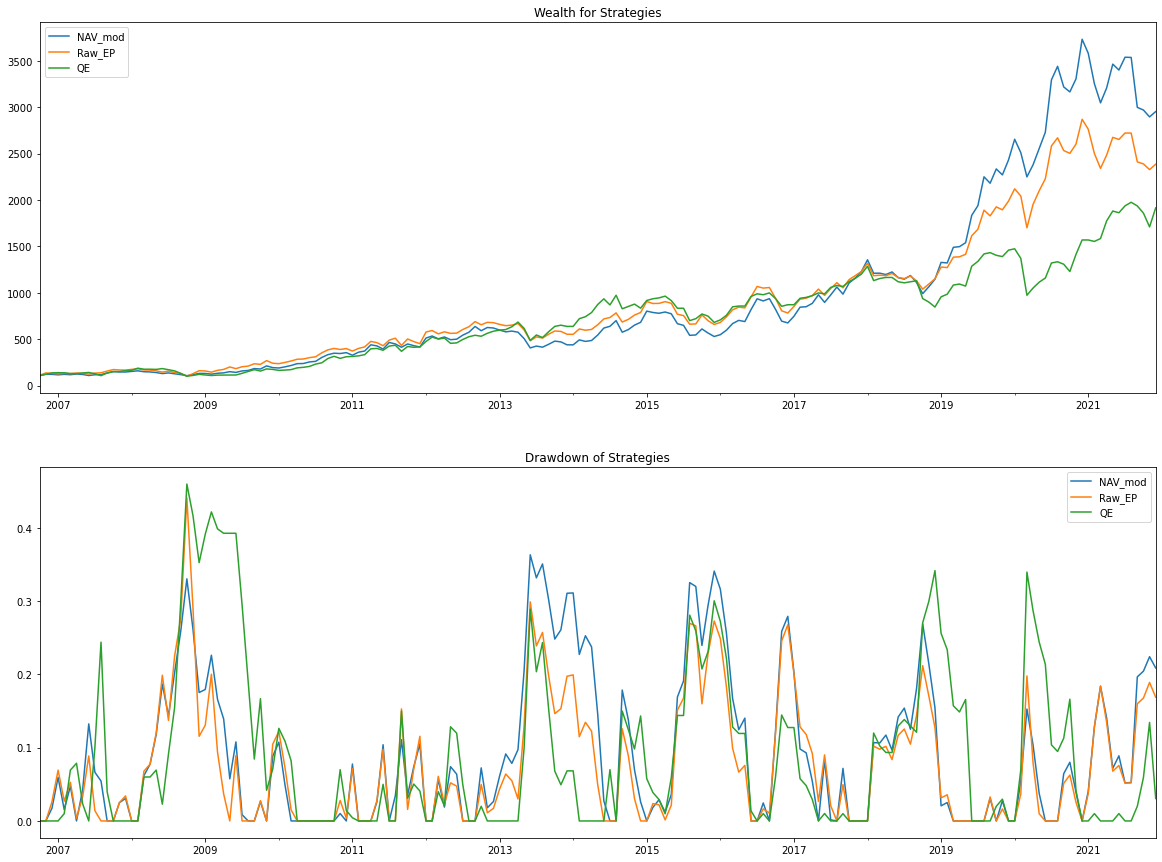

In [595]:
monthly_vol_target = scaled_ret.resample('1m').sum()
df = pd.DataFrame({'NAV_mod':monthly_vol_target, 'Raw_EP': monthly_ret,'QE':qedge_returns})
df = df.dropna()
# plt.scatter(df['QE'], df['NAV'])

vols = df.std(axis=0)*np.sqrt(12)
# scaler = vols['QE'] / vols['NAV']
df['NAV_mod'] = vols['QE'] / vols['NAV_mod'] * df['NAV_mod']
df['Raw_EP'] = vols['QE'] / vols['Raw_EP'] * df['Raw_EP']
wealth = (1 + df).cumprod(axis=0) * 100
ax = plt.subplot(211)
wealth.plot(ax=ax)
plt.title("Wealth for Strategies")
max_wealth = wealth.cummax(axis=0)
dd = 1 - wealth / max_wealth
ax = plt.subplot(212)
dd.plot(ax=ax)
plt.title("Drawdown of Strategies")
df.mean(axis=0) / df.std(axis=0) * np.sqrt(12)